In [41]:
import warnings
warnings.filterwarnings("ignore")
import numpy as np
from scipy.optimize import minimize
from scipy.stats import chi2
from scipy.linalg import sqrtm
from numpy.linalg import det
import numpy.linalg as LA
import matplotlib.pyplot as plt
import math
from tqdm import tqdm
import numpy as np
from scipy.stats import invwishart as iw        
import matplotlib.pyplot as plt

def plot_ellipse(covariance, ax, label_t="", linestyle='', alpha_val=0.25, color_def='red', center = [0, 0]):
    if covariance.shape[0] == 2:
        x_el = np.array([np.sin(np.linspace(0, 2*math.pi, num=63)), np.cos(np.linspace(0, 2*math.pi, num=63))])
        C = np.linalg.cholesky(covariance)
        y_el = np.dot(C, x_el)
        if len(linestyle) > 0:
            if len(label_t) > 0:
                ax.plot(y_el[0] + center[0], y_el[1] + center[1], label=label_t, alpha=alpha_val, color=color_def, linestyle=linestyle)
            else:
                ax.plot(y_el[0] + center[0], y_el[1] + center[1], alpha=alpha_val, color=color_def, linestyle=linestyle)            
        else:
            if len(label_t) > 0:
                ax.plot(y_el[0] + center[0], y_el[1] + center[1], label=label_t, alpha=alpha_val, color=color_def)
            else:
                ax.plot(y_el[0] + center[0], y_el[1] + center[1], alpha=alpha_val, color=color_def) 
                

In [42]:
def inv(A):
    return LA.inv(A)

def relu(v):
    threshold = 1E-5
    if v < threshold:
        return np.log1p(1 + np.exp(v))* threshold /np.log1p(1+np.exp(threshold))
    else:
        return v



def pinv(A):
    RELU = np.vectorize(relu)
    tmp_eig, tmp_egv = LA.eig(A)
    M_inv = tmp_egv @ np.diag(1/RELU(tmp_eig)) @ tmp_egv.T
    M = tmp_egv @ np.diag(RELU(tmp_eig)) @ tmp_egv.T
    return M_inv

def generate_covariance(true_mu, dims, df):
    S = (np.tril(iw.rvs(df, 1, size=dims**2).reshape(dims, dims)))*df
    cov = np.dot(S, S.T)
    while(abs(np.linalg.det(cov)) < 1.5):
        cov = cov + 0.5*np.diag(np.diag(cov))
    mu = np.random.multivariate_normal(true_mu, cov, 1)[0]

    return mu, cov

def mutual_covariance(cov_a, cov_b):
    D_a, S_a = np.linalg.eigh(cov_a)
    D_a_sqrt = sqrtm(np.diag(D_a))
    D_a_sqrt_inv = inv(D_a_sqrt)
    M = np.dot(np.dot(np.dot(np.dot(D_a_sqrt_inv, inv(S_a)), cov_b), S_a), D_a_sqrt_inv)    # eqn. 10 in Sijs et al.
    D_b, S_b = np.linalg.eigh(M)
    D_gamma = np.diag(np.clip(D_b, a_min=1.0, a_max=None))   # eqn. 11b in Sijs et al.
    return np.dot(np.dot(np.dot(np.dot(np.dot(np.dot(S_a, D_a_sqrt), S_b), D_gamma), inv(S_b)), D_a_sqrt), inv(S_a))  # eqn. 11a in Sijs et al

def get(dims, df):
    true_mu = np.zeros((dims, ))

    x_ac, C_ac = generate_covariance(true_mu, dims, df)
    x_c, C_c = generate_covariance(true_mu, dims, df)
    x_bc, C_bc = generate_covariance(true_mu, dims, df)

    C_a = LA.inv(LA.inv(C_ac) + LA.inv(C_c))
    C_b = LA.inv(LA.inv(C_bc) + LA.inv(C_c))

    x_a = C_a @ (LA.inv(C_ac) @ x_ac + LA.inv(C_c) @ x_c)
    x_b = C_b @ (LA.inv(C_bc) @ x_bc + LA.inv(C_c) @ x_c)

    C_fus = LA.inv(LA.inv(C_a) + LA.inv(C_b) - LA.inv(C_c))

    x_fus = C_fus @ (LA.inv(C_ac) @ x_ac + LA.inv(C_bc) @ x_bc + LA.inv(C_c) @ x_c)

    return x_a.reshape(1, dims), x_b.reshape(1, dims), C_a, C_b, C_fus, x_fus

def get_critical_value(dimensions, alpha):
    return chi2.ppf((1 - alpha), df=dimensions)

eta = get_critical_value(2, 0.05)

In [43]:
df = 100
x_a, x_b, C_a, C_b, C_fus, t_x_fus = get(2, df)
print(C_a)
x_a = x_a.reshape(1, 2)
x_b = x_b.reshape(1, 2)
S_0 = np.array([0, 0, 0])

[[0.78564812 0.66244376]
 [0.66244376 1.20902304]]


In [44]:
class Constraints():
    def __init__(self, eta):
        self.e = eta
    
    def update_eta(self, new_eta):
        self.e=new_eta
    
    def objective(self, S):
        G = np.zeros((2, 2))
        G[np.tril_indices(2)] = S
        return np.trace(G @ G.T)

    def constraint1(self, S):
        G = np.zeros((2, 2))
        G[np.tril_indices(2)] = S
        A = G@G.T - 1e-10*np.identity(2)
        return np.linalg.eigh(A)[0][0]

    def constraint2(self, S):        
        G = np.zeros((2, 2))
        G[np.tril_indices(2)] = S
        A = G@G.T - 1e-10*np.identity(2)
        return np.linalg.eigh(A)[0][0]

    def prob_constraint(self, S):
        G = np.zeros((2, 2))
        G[np.tril_indices(2)] = S
        C_c_inv = LA.inv(mutual_covariance(C_a, C_b) + 1e-10*np.identity(2) + G@G.T)

        C_ac = pinv(inv(C_a) - C_c_inv)
        C_bc = pinv(inv(C_b) - C_c_inv)

        C_abc_inv_inv = pinv(pinv(C_ac) + pinv(C_bc))
        C_abc_inv = pinv(C_ac + C_bc)

        x_c = (C_abc_inv_inv @ (LA.inv(C_ac) @ x_a.T + LA.inv(C_bc) @ x_b.T)).T

        x_ac = (C_ac @ (inv(C_a) @ x_a.T - C_c_inv @ x_c.T)).T
        x_bc = (C_bc @ (inv(C_b) @ x_b.T - C_c_inv @ x_c.T)).T

        f = ((x_ac - x_bc) @ LA.inv(C_ac+C_bc) @ (x_ac - x_bc).T)[0][0]
        return self.e-f

    def debug(self, S):
        print(S)
        print ('objective is',self.objective(S))
        print ('constraint1 is ',self.constraint1(S))
        print ('constraint2 is ',self.constraint2(S))
        print ('prob_constraint is ',self.prob_constraint(S))

In [45]:
constraints = Constraints(eta)

con1 = {'type': 'ineq', 'fun': constraints.constraint1}
con2 = {'type': 'ineq', 'fun': constraints.constraint2}
con3 = {'type': 'eq', 'fun': constraints.prob_constraint}
cons = [con1, con2, con3]

In [46]:
constraints.update_eta(get_critical_value(2, 0.05))
sol = minimize(constraints.objective, S_0, method='trust-constr', constraints=cons, tol=1e-5)
print(sol)

 barrier_parameter: 6.400000000000003e-06
 barrier_tolerance: 6.400000000000003e-06
          cg_niter: 165
      cg_stop_cond: 1
            constr: [array([0.02892189]), array([0.02892189]), array([-3.19744231e-13])]
       constr_nfev: [776, 776, 776]
       constr_nhev: [0, 0, 0]
       constr_njev: [0, 0, 0]
    constr_penalty: 1.0
  constr_violation: 3.197442310920451e-13
    execution_time: 1.1869616508483887
               fun: 0.19494556876943875
              grad: array([ 0.41085595, -0.39477521,  0.6746349 ])
               jac: [array([[0.25430532, 0.0832786 , 0.0653406 ]]), array([[0.25430532, 0.0832786 , 0.0653406 ]]), array([[ 11.25618881, -10.82585561,  18.49447066]])]
   lagrangian_grad: array([ 5.82506869e-06, -7.86338714e-06, -8.14816329e-06])
           message: '`gtol` termination condition is satisfied.'
            method: 'tr_interior_point'
              nfev: 776
              nhev: 0
               nit: 116
             niter: 116
              njev: 194
   

In [47]:
constraints.debug(sol.x)
C_c_EI =  mutual_covariance(C_a, C_b) + 1e-10*np.identity(2)

G = np.zeros((2, 2))
G[np.tril_indices(2)] = sol.x
C_c_PC_05 = C_c_EI + G @ G.T


constraints.update_eta(get_critical_value(2, 0.01))
sol = minimize(constraints.objective, S_0, method='trust-constr', constraints=cons, tol=1e-5)
print("================")
constraints.debug(sol.x)
G = np.zeros((2, 2))
G[np.tril_indices(2)] = sol.x

C_c_PC_01 = C_c_EI + G @ G.T

[ 0.20542797 -0.1973876   0.33731744]
objective is 0.19494556876943875
constraint1 is  0.028921891517853356
constraint2 is  0.028921891517853356
prob_constraint is  -3.197442310920451e-13
[ 0.1228574  -0.27376943  0.03826713]
objective is 0.09150801600709442
constraint1 is  0.0002421843633518654
constraint2 is  0.0002421843633518654
prob_constraint is  -3.3539669708204656e-07


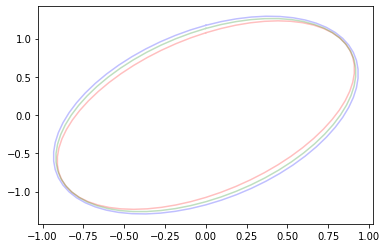

In [48]:
ax = plt.axes()
plot_ellipse(C_c_EI, ax)
plot_ellipse(C_c_PC_05, ax, color_def="blue")
plot_ellipse(C_c_PC_01, ax, color_def="green")

In [49]:
fus_PC_05 = inv(inv(C_a) + inv(C_b) - inv(C_c_PC_05))
fus_PC_01 = inv(inv(C_a) + inv(C_b) - inv(C_c_PC_01))
fus_EI = inv(inv(C_a) + inv(C_b) - inv(C_c_EI))

0.44974040292363826
0.4751854404109923


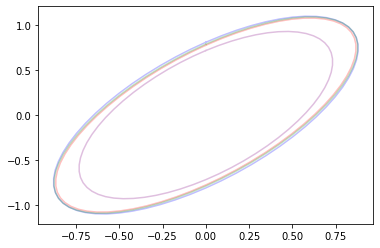

In [50]:
plt.cla()
plt.clf()
ax = plt.axes()
plot_ellipse(fus_EI, ax, color_def="blue")
plot_ellipse(fus_PC_05, ax)
plot_ellipse(fus_PC_01, ax, color_def="green")
plot_ellipse(C_fus, ax, color_def="purple")

print(LA.det(fus_PC_05))
print(LA.det(fus_PC_01))

In [29]:
print(get_critical_value(2, 0.05))
print(get_critical_value(2, 0.01))

5.991464547107979
9.21034037197618


In [30]:
import matplotlib.pyplot as plt

def f(x, y):
    z = np.array([x, y])
    return prob_constraint(z)

fig = plt.figure()
ax = plt.axes(projection='3d')
x = np.linspace(0, 1, 100)
y = np.linspace(0, 1, 100)
X, Y = np.meshgrid(x, y)



for index_x, i in enumerate(x):
    for index_y, j in enumerate(y):
        
        


SyntaxError: unexpected EOF while parsing (<ipython-input-30-17d06c411a0d>, line 18)